In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from scipy.optimize import fmin

In [45]:
def storage(S0, k, alpha, data):
    dt = 1
    S = np.zeros(len(data))
    S[0] = S0
    for i in range(len(data)-1):
        S[i+1] = S[i] - k * dt * S[i] ** alpha + data['P'].iloc[i] * dt - data['Pe'].iloc[i] * dt 
        if S[i+1] < 0:
            S[i+1] = 0
    data['S'] = S
    return data

In [46]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
files = glob.glob(f"{data_folder}\\*.parquet")
files

['C:\\Users\\anne-\\OneDrive - Delft University of Technology\\Documenten\\Environmental Engineering MSc\\ENVM1502-Catchment-model\\Data\\combined_data.parquet',
 'C:\\Users\\anne-\\OneDrive - Delft University of Technology\\Documenten\\Environmental Engineering MSc\\ENVM1502-Catchment-model\\Data\\df_combined_data.parquet',
 'C:\\Users\\anne-\\OneDrive - Delft University of Technology\\Documenten\\Environmental Engineering MSc\\ENVM1502-Catchment-model\\Data\\df_data.parquet']

In [47]:
df_data = pd.read_parquet(files[0]).dropna()


In [48]:
#df_data = pd.read_parquet(files[0]).dropna()
files = glob.glob(f"{data_folder}\\EP\\combined*.parquet")
df_EP = pd.read_parquet(files[1]).dropna()


In [49]:
df_data_comb = pd.concat([df_data, df_EP], axis=1)
df_data_comb.dropna(inplace=True)
df_data_comb.head()

,T,Pev,P,Q,Pe
1980-01-01,-4.244118,0.212411,0.000000,2.769318,0.212411
1980-01-02,-3.066830,0.167835,0.000000,2.639043,0.167835
1980-01-03,-6.372549,0.235660,0.023756,2.574587,0.235660
1980-01-04,-10.202124,0.167202,0.000000,2.413105,0.167202
1980-01-05,-7.726471,0.192151,0.000000,2.250887,0.192151


In [50]:
S0 = 75 #mm
k = 0.01 #per day
t0 = 0 #days
tmax = 200 #days
dt = 1 #days
alpha = 1 

In [51]:
df_storage = storage(S0, k, alpha, df_data_comb)

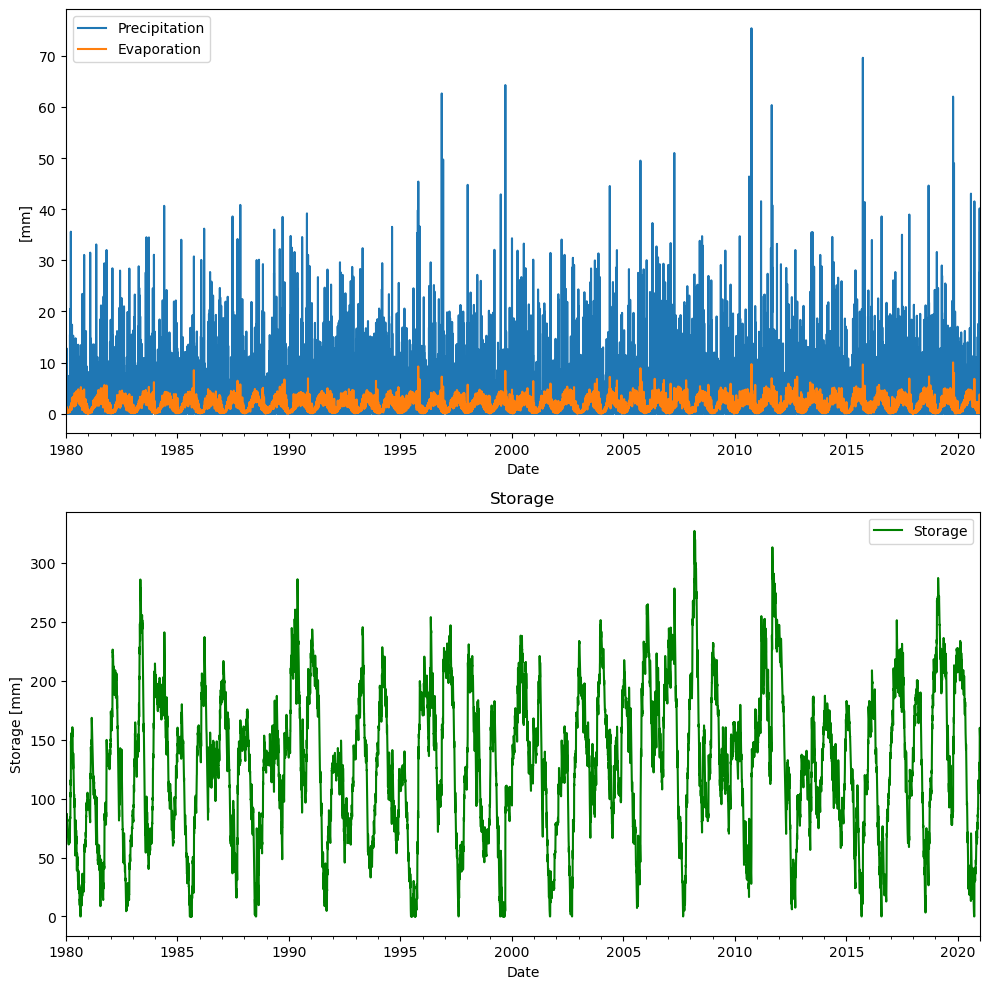

In [52]:
fig, ax = plt.subplots(2, figsize=(10,10))
df_storage['P'].plot(ax=ax[0], ylabel='[mm]', label='Precipitation')
df_storage['Pe'].plot(ax=ax[0], label='Evaporation')
df_storage['S'].plot(ax=ax[1], label='Storage', color='green', ylabel='Storage [mm]', title='Storage')
ax[0].set_xlabel('Date')
ax[1].set_xlabel('Date')
fig.tight_layout()
ax[0].legend()
ax[1].legend()

### Linear model 

Due to the low potential evaporation compared to the precipitation, the storage is increasing. With a k-factor of 0.1, the storge is fluctuating between 100 en 400 mm. Alpha is set to 1, so it is a linear model. In practice this is not the case, due to the spatial heterogenity of the precipitation, but also the spatial heterogeneity in systems states. This means that there is a spatial difference in filling the storages, as a result from the past inputs and water releases. Next to this, the storage threshold could also differ over the area, because for example the soil type is not necessarily the same over the entire Hudson Basin. 

In [54]:
def fobj(p, S0, df):
    k, alpha = p
    df_s = storage(S0, k, alpha, df)
    df_s['Q'] = k * df_s['S'] ** alpha
    Q_mean = df_s.Q.mean()
    P_mean = df_s.P.mean()
    runoff = Q_mean / P_mean
    runoff_model = 0.6
    sse = np.sum((runoff - runoff_model) ** 2)
    return sse


popt = fmin(fobj, [0.005, 1], args=(S0, df_data_comb))
k_opt, alpha_opt = popt

print('Value for k', k_opt)
print('Value for alpha:', alpha_opt)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 72
Value for k 0.006692899019937035
Value for alpha: 2.45571425070166


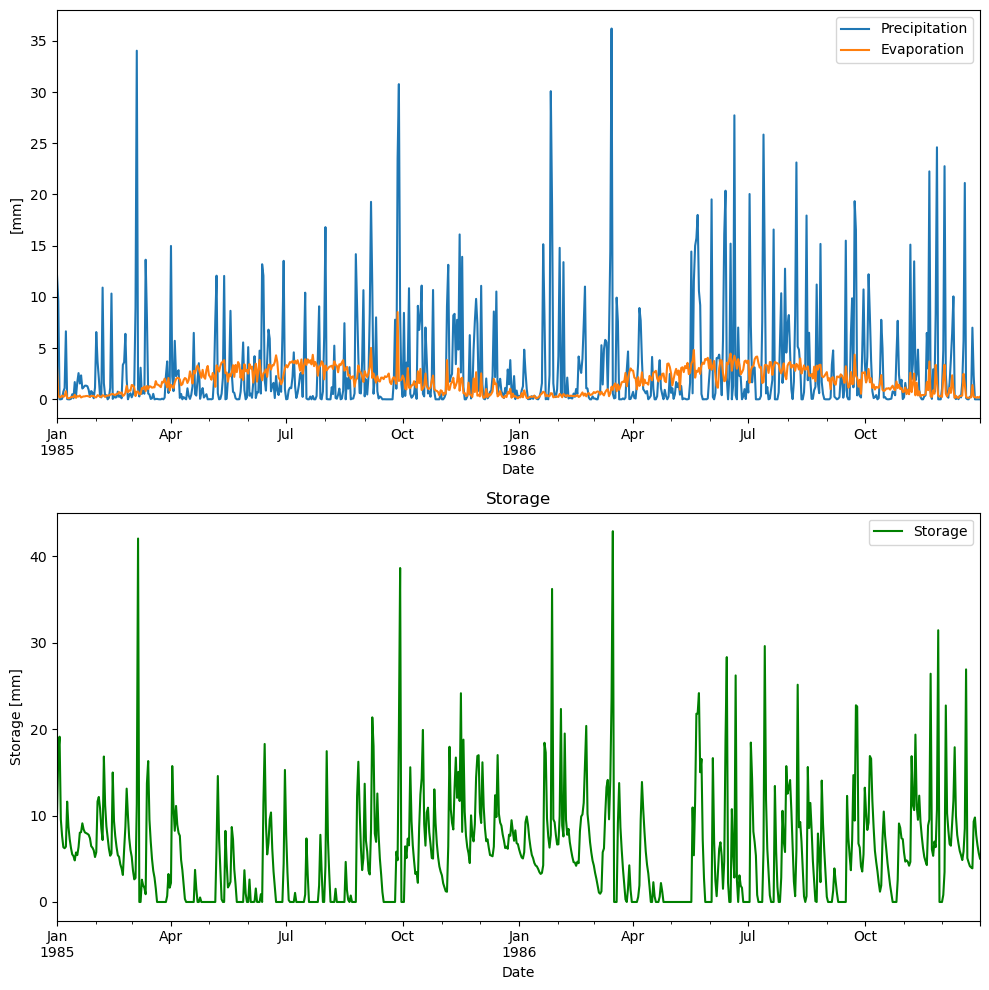

In [55]:
df_storage = storage(S0, k_opt, alpha_opt, df_data_comb)

fig, ax = plt.subplots(2, figsize=(10,10))
df_storage.loc['1985':'1986','P'].plot(ax=ax[0], ylabel='[mm]', label='Precipitation')
df_storage.loc['1985':'1986','Pe'].plot(ax=ax[0], label='Evaporation')
df_storage.loc['1985':'1986','S'].plot(ax=ax[1], label='Storage', color='green', ylabel='Storage [mm]', title='Storage')
ax[0].set_xlabel('Date')
ax[1].set_xlabel('Date')
fig.tight_layout()
ax[0].legend()
ax[1].legend()